In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import polars as pl
import duckdb
import numpy as np
import sys
from scipy import signal
import polars as pl
import numpy as np
from scipy import stats
sys.path.append('../')
from database_calls import get_device_as_pl_df, get_settings_for_pb_calcs
from viz_funcs import plot_feature_distributions
import pandas as pd

sys.path.append('../..')
from preproc.time_domain_transforms import epoch_df_by_timesegment

# Import data

In [3]:
# Connect to database
DATABASE_PATH = '/media/shortterm_ssd/Clay/databases/duckdb/rcs-db.duckdb'
con = duckdb.connect(database=DATABASE_PATH, read_only=True)

# Feature Engineering

## Spectral Feature Distribution Visualization

In [4]:
# Todo: Epoch data
# 2. convert to numpy array
# sum along specific bands
# Convert back to df 
# Visualize



# Figure out how to integrate (2) into TSFlex
# TODO: Integrate into TSFlex, and neural network training

In [15]:
devs = ['02L', '02R', '03L', '03R', '07L', '07R', '09L', '09R', '16L', '16R']
td_streams = ['TD_BG', 'TD_key2', 'TD_key3']
band_ranges = {'Delta': [0.5, 4], 'Theta': [4,8], 'Alpha': [8, 12], 'Beta': [12, 30], 'Gamma': [30, 100]}


In [ ]:

for dev in devs:
    # Get and epoch time series
    dev_df = get_device_as_pl_df(dev, db_con=con)
    dev_df = epoch_df_by_timesegment(dev_df, interval='2s', period='2s', groupby_cols=['SessionIdentity', 'SleepStage'], align_with_PB_outputs=False)
    

    for td_stream in td_streams:
        # Get PSD for each epoch (no averaging)
        td = dev_df.select(td_stream).to_numpy().T
        f, pxx = signal.welch(td, fs=500, nperseg=1000, noverlap=0, axis=-1)
        pb_bands = {key: np.log(np.sum(pxx[:, np.where(
                (f >= pb[0]) & (f < pb[1]+0.1) )[0] ], axis=-1))
            for key, pb in band_ranges.items()}
        
        # Plot distributions
        fig = plot_feature_distributions(pl.DataFrame(pb_bands | {'SleepStage': dev_df.select('SleepStage').to_numpy().squeeze()}).with_columns(
            pl.col('SleepStage').map_dict({2:'N3', 3: 'N2', 4: 'N1', 5: 'REM', 6: 'Wake'}).cast(pl.Categorical) ),
            partition_col='SleepStage', melt_cols=list(pb_bands.keys()), 
            value_name='Power',
            color_ordering=['N3', 'N2', 'N1', 'REM', 'Wake'],
            row_ordering=list(band_ranges.keys()).reverse()
            )

        fig.update_layout(title=f'{dev} - {td_stream}: Log Power Band Distributions by Sleep Stage')
        fig.write_html(f'/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/feature_engineering/powerband_distributions/RCS{dev}_{td_stream}_log_power_band_distributions_by_sleep_stage.html')

## Catch 22 Feature Extraction

In [11]:
import pycatch22 as catch22

In [12]:
dev_df = get_device_as_pl_df('02L', db_con=con)

In [16]:

def_df = dev_df.with_columns([
    (pl.col(td_stream) - pl.col(td_stream).mean()) / pl.col(td_stream).std() for td_stream in td_streams
])

dev_df = epoch_df_by_timesegment(dev_df, interval='30s', period='30s', groupby_cols=['SessionIdentity', 'SleepStage'], vector_cols=['localTime'], align_with_PB_outputs=False)


In [17]:
time_series = dev_df.select('TD_key2').to_numpy().T

In [18]:
time_series.shape

(5721, 15000)

In [19]:
feats = []
time_series_list = time_series.tolist()
for i in range(len(time_series_list)):
    feats.append(catch22.catch22_all(time_series_list[i])['values'])
    if i % 100 == 0:
        print(f'{i} / {len(time_series_list)} done')

features = np.array(feats)


0 / 5721 done
100 / 5721 done
200 / 5721 done
300 / 5721 done
400 / 5721 done
500 / 5721 done
600 / 5721 done
700 / 5721 done
800 / 5721 done
900 / 5721 done
1000 / 5721 done
1100 / 5721 done
1200 / 5721 done
1300 / 5721 done
1400 / 5721 done
1500 / 5721 done
1600 / 5721 done
1700 / 5721 done
1800 / 5721 done
1900 / 5721 done
2000 / 5721 done
2100 / 5721 done
2200 / 5721 done
2300 / 5721 done
2400 / 5721 done
2500 / 5721 done
2600 / 5721 done
2700 / 5721 done
2800 / 5721 done
2900 / 5721 done
3000 / 5721 done
3100 / 5721 done
3200 / 5721 done
3300 / 5721 done
3400 / 5721 done
3500 / 5721 done
3600 / 5721 done
3700 / 5721 done
3800 / 5721 done
3900 / 5721 done
4000 / 5721 done
4100 / 5721 done
4200 / 5721 done
4300 / 5721 done
4400 / 5721 done
4500 / 5721 done
4600 / 5721 done
4700 / 5721 done
4800 / 5721 done
4900 / 5721 done
5000 / 5721 done
5100 / 5721 done
5200 / 5721 done
5300 / 5721 done
5400 / 5721 done
5500 / 5721 done
5600 / 5721 done
5700 / 5721 done


In [20]:
fnames22 = catch22.catch22_all(time_series_list[i])['names']
df = pd.DataFrame(features, columns=fnames22)

In [21]:
df['SleepStage'] = dev_df.select('SleepStage').to_numpy().squeeze()
data = df

In [ ]:
data.shape

(5721, 23)

## Custom feature extraction

In [37]:
import itertools
from sklearn.linear_model import LinearRegression
from collections import OrderedDict

def custom_feature_extraction(vec: np.ndarray, sampling_frequency: int, window_size: int, additional_features: dict = {}):
    """Extracts custom features from a vector of time series data.

    Args:
        vec (np.array): Vector of time series data
        sampling_frequency (int): Sampling frequency of the time series data
        additional_features (dict, optional): Additional features to extract. Defaults to {}. Should be dict of {feature_name: feature_function}

    Returns:
        np.array: Vector of extracted features
    """
    
    features = OrderedDict()
    
    # Time domain features
    features['mean'] = np.mean(vec)
    features['std'] = np.std(vec)
    features['min'] = np.min(vec)
    features['max'] = np.max(vec)
    features['median'] = np.median(vec)
    features['samples_above'] = np.sum(vec > features['mean'] + features['std'])
    features['samples_below'] = np.sum(vec < features['mean'] - features['std'])
    
    # Frequency domain features
    f, pxx = np.log10(signal.welch(vec, fs=sampling_frequency, nperseg=window_size, noverlap=0, axis=-1))
    band_ranges = {'Delta': [0.5, 4], 'Theta': [4,8], 'Alpha': [8, 12], 'Beta': [12, 30], 'Gamma': [30, 100]}
    
    # Get powerbands
    features |= {key: np.sum(
                        pxx[ np.where( (f >= pb[0]) & (f < pb[1]+0.1) )[0] ],
                    axis=-1)
                for key, pb in band_ranges.items()}
    
    # Get powerband ratios
    features |= {f'{pb_combo[0]}/{pb_combo[1]}': features[pb_combo[0]] / features[pb_combo[1]] for pb_combo in itertools.combinations(band_ranges.keys(), 2)}
    
    # Slope of linear regression of PSD
    model = LinearRegression().fit(np.arange(len(vec)).reshape(-1,1), vec)
    features['slope'] = model.coef_[0]
    
    if additional_features:
        features |= OrderedDict({feature_name: feature_function(vec) for feature_name, feature_function in additional_features.items()})
    
    return np.array(list(features.values()))
    
    

In [42]:
def get_feature_names(additional_features: dict = {}):
    band_ranges = {'Delta': [0.5, 4], 'Theta': [4,8], 'Alpha': [8, 12], 'Beta': [12, 30], 'Gamma': [30, 100]}
    return ['mean', 'std', 'min', 'max', 'median', 'samples_above', 'samples_below'] + \
            list(band_ranges.keys()) + \
            [f'{pb_combo[0]}/{pb_combo[1]}' for pb_combo in itertools.combinations(band_ranges.keys(), 2)] + \
            ['slope'] + \
            list(additional_features.keys())

In [38]:
feat_extract = np.vectorize(custom_feature_extraction, signature='(n),(),()->(m)')
features = feat_extract(time_series, 500, 1000)
data_custom = pd.DataFrame(features, columns=get_feature_names())
data_custom = (data_custom - data_custom.mean()) / data_custom.std()
data_custom['SleepStage'] =  dev_df.select('SleepStage').to_numpy().squeeze()

In [48]:
data_custom.shape

(5721, 24)

## Full PSD vector as feature

In [51]:
x = dev_df.select('TD_key3').to_numpy().T
y = dev_df.select('TD_key2').to_numpy().T
z = dev_df.select('TD_BG').to_numpy().T
f, pxx = signal.welch(x, fs=500, nperseg=500, noverlap=250, axis=-1)
f, pyy = signal.welch(y, fs=500, nperseg=500, noverlap=250, axis=-1)
f, pzz = signal.welch(z, fs=500, nperseg=500, noverlap=250, axis=-1)
pxy = np.mean(np.concatenate([pxx[:,:,np.newaxis], pyy[:,:,np.newaxis]], axis=-1), axis=-1)

(5721, 251)

## TSFresh Feature Extraction

In [4]:
from tsfresh import extract_features


In [5]:

dev_df = get_device_as_pl_df('02L', db_con=con)


dev_df = epoch_df_by_timesegment(dev_df, interval='30s', period='30s', groupby_cols=['SessionIdentity', 'SleepStage'], vector_cols=['localTime'], align_with_PB_outputs=False)

dev_df = dev_df.with_row_count(name='epoch_num').explode(['localTime_vec', 'TD_BG', 'TD_key2', 'TD_key3'])
    


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [6]:
dev_df.height

85815000

In [7]:

time_series = dev_df.head(815000).select(['localTime_vec', 'epoch_num', 'TD_BG', 'TD_key2', 'TD_key3']).to_pandas()
extracted_features = extract_features(time_series, column_id="epoch_num", column_sort="localTime_vec")  

Feature Extraction: 100%|██████████| 165/165 [25:34<00:00,  9.30s/it]  


In [10]:
extracted_features.shape

(55, 2349)

In [ ]:
devs = ['02L', '02R', '03L', '03R', '07L', '07R', '09L', '09R', '16L', '16R']
td_streams = ['TD_BG', 'TD_key2', 'TD_key3']
band_ranges = {'Delta': [0.5, 4], 'Theta': [4,8], 'Alpha': [8, 12], 'Beta': [12, 30], 'Gamma': [30, 100]}

for dev in devs:
    # Get and epoch time series
    dev_df = get_device_as_pl_df(dev, db_con=con)
    dev_df = epoch_df_by_timesegment(dev_df, interval='2s', period='2s', groupby_cols=['SessionIdentity', 'SleepStage'], vector_cols=['localTime'], align_with_PB_outputs=False)
    dev_df = dev_df.with_row_count().explode(['localTime_vec', 'TD_BG', 'TD_key2', 'TD_key3']).to_pandas(zero_copy_only=True)

    extracted_features = extract_features(dev_df, column_id="row_nr", column_sort="localTime_vec")   

# Model Training

In [23]:
from pycaret.classification import *

In [54]:
labels = dev_df.select('SleepStage').to_numpy().squeeze()

In [59]:
i = 0
for data in (pzz, pxy):
    i += 1
    print(f'{i}__________________________________________________________')
    psd_dict = {f'psd_{i}': data[:,i] for i in range(data.shape[1])}
    data = pd.DataFrame(psd_dict | {'SleepStage': labels}) 
    s = setup(data, target = 'SleepStage', session_id = 0)

    lgbm = create_model('lightgbm')

    # define tuning grid
    lgbm_grid = {'max_depth' : [2, 4, 6, 8, 10, 12]}
    tuned_lgbm = tune_model(lgbm)
    pull()

1__________________________________________________________


,Description,Value
0,Session id,0
1,Target,SleepStage
2,Target type,Multiclass
3,Target mapping,"2.0: 0, 3.0: 1, 4.0: 2, 5.0: 3, 6.0: 4"
4,Original data shape,"(5721, 252)"
5,Transformed data shape,"(5721, 252)"
6,Transformed train set shape,"(4004, 252)"
7,Transformed test set shape,"(1717, 252)"
8,Numeric features,251
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7930,0.9341,0.7930,0.7696,0.7756,0.6922,0.6969
1,0.7830,0.9375,0.7830,0.7621,0.7645,0.6763,0.6818
2,0.7880,0.9488,0.7880,0.7705,0.7706,0.6837,0.6897
3,0.7855,0.9511,0.7855,0.7765,0.7676,0.6774,0.6859
4,0.8000,0.9418,0.8000,0.7894,0.7891,0.7046,0.7081
5,0.8000,0.9563,0.8000,0.7965,0.7897,0.7051,0.7093
6,0.7975,0.9543,0.7975,0.8091,0.7777,0.6943,0.7028
7,0.7875,0.9450,0.7875,0.7790,0.7704,0.6843,0.6890
8,0.7575,0.9359,0.7575,0.7376,0.7398,0.6387,0.6438


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7631,0.9264,0.7631,0.7413,0.7471,0.6475,0.6522
1,0.7581,0.9324,0.7581,0.7425,0.7436,0.6397,0.6446
2,0.7855,0.9503,0.7855,0.7745,0.7700,0.6789,0.6859
3,0.7980,0.9487,0.7980,0.7924,0.7828,0.6959,0.7046
4,0.7925,0.9446,0.7925,0.7832,0.7818,0.6929,0.6968
5,0.8000,0.9551,0.8000,0.7916,0.7862,0.7006,0.7076
6,0.7900,0.9521,0.7900,0.7910,0.7769,0.6835,0.6923
7,0.7875,0.9431,0.7875,0.7740,0.7745,0.6842,0.6888
8,0.7600,0.9311,0.7600,0.7461,0.7463,0.6437,0.6484


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
2__________________________________________________________


,Description,Value
0,Session id,0
1,Target,SleepStage
2,Target type,Multiclass
3,Target mapping,"2.0: 0, 3.0: 1, 4.0: 2, 5.0: 3, 6.0: 4"
4,Original data shape,"(5721, 252)"
5,Transformed data shape,"(5721, 252)"
6,Transformed train set shape,"(4004, 252)"
7,Transformed test set shape,"(1717, 252)"
8,Numeric features,251
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7955,0.9493,0.7955,0.7836,0.7827,0.6985,0.7014
1,0.8005,0.9549,0.8005,0.7972,0.7984,0.7133,0.7134
2,0.7880,0.9458,0.7880,0.7826,0.7766,0.6863,0.6910
3,0.8279,0.9577,0.8279,0.8120,0.8173,0.7500,0.7518
4,0.8150,0.9600,0.8150,0.8052,0.8083,0.7322,0.7327
5,0.8225,0.9652,0.8225,0.8219,0.8210,0.7434,0.7439
6,0.8150,0.9609,0.8150,0.8083,0.8106,0.7318,0.7324
7,0.8200,0.9615,0.8200,0.8055,0.8077,0.7361,0.7384
8,0.8225,0.9611,0.8225,0.8227,0.8215,0.7443,0.7448


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7506,0.9405,0.7506,0.7425,0.7450,0.6388,0.6396
1,0.8080,0.9479,0.8080,0.8037,0.8052,0.7233,0.7236
2,0.7980,0.9460,0.7980,0.8002,0.7945,0.7063,0.7080
3,0.8180,0.9571,0.8180,0.8153,0.8153,0.7359,0.7368
4,0.8225,0.9594,0.8225,0.8099,0.8147,0.7419,0.7427
5,0.8125,0.9571,0.8125,0.8148,0.8125,0.7289,0.7296
6,0.8175,0.9603,0.8175,0.8149,0.8159,0.7368,0.7370
7,0.8475,0.9629,0.8475,0.8446,0.8411,0.7763,0.7784
8,0.8125,0.9589,0.8125,0.8209,0.8159,0.7327,0.7330


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


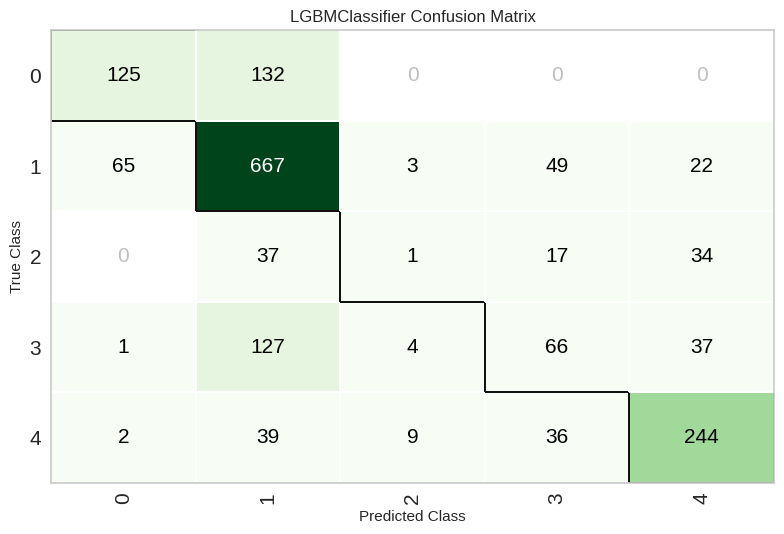

In [50]:
s.plot_model(tuned_lgbm, plot = 'confusion_matrix')

# Model Eval

# Visualization